This will autoload the new/updated packages

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

This is the batch size

In [3]:
bs = 5
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

Function to read from JSON file

In [4]:
def readJSONFile(path):
    import json
    with open(path) as f:
        data = json.load(f)
    return data

In [5]:
#dataPath=Path('/home/manoj/Documents/data/data/')
dataPath=Path('c:/Users/manoj/PycharmProjects/data/PlantPathology2020/')
dataPath.ls()

[WindowsPath('c:/Users/manoj/PycharmProjects/data/PlantPathology2020/150X200'),
 WindowsPath('c:/Users/manoj/PycharmProjects/data/PlantPathology2020/600X800'),
 WindowsPath('c:/Users/manoj/PycharmProjects/data/PlantPathology2020/images'),
 WindowsPath('c:/Users/manoj/PycharmProjects/data/PlantPathology2020/sample_submission.csv'),
 WindowsPath('c:/Users/manoj/PycharmProjects/data/PlantPathology2020/test.csv'),
 WindowsPath('c:/Users/manoj/PycharmProjects/data/PlantPathology2020/train.csv')]

In [6]:
trainImagesDf=pd.read_csv(dataPath/'train.csv')

In [7]:
trainImagesDf

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [8]:
x=np.asarray(trainImagesDf[["healthy","multiple_diseases","rust","scab"]])
options = { 0:"healthy"
           ,1:"multiple_diseases"
           ,2:"rust"
           ,3:"scab"
}
trainImagesDf["label"]=[options[np.argmax(arr)] for arr in x]
trainImagesDf["name"] = trainImagesDf["image_id"]+'.jpg'
#testImagesDf
trainDf = trainImagesDf[["image_id","label"]]
df = trainImagesDf[["name","label"]]
df

,name,label
0,Train_0.jpg,scab
1,Train_1.jpg,multiple_diseases
2,Train_2.jpg,healthy
3,Train_3.jpg,rust
4,Train_4.jpg,healthy
...,...,...
1816,Train_1816.jpg,scab
1817,Train_1817.jpg,healthy
1818,Train_1818.jpg,healthy
1819,Train_1819.jpg,rust


In [9]:
minSamples=10
duplicateDf=pd.DataFrame()

for label in df["label"].unique():
    length=0
    
    x=min
    y=len(df[df["label"]==label])
    multiplier=1
    if(y<minSamples):
        multiplier=int(minSamples/y)
        y=y*multiplier
    #length=y
    #print("{} {} {}".format(y, multiplier, length))
    duplicateDf=duplicateDf.append([df[df["label"]==label]]*multiplier,ignore_index=True)

df=duplicateDf

In [9]:
df

,name,label
0,Train_0.jpg,scab
1,Train_1.jpg,multiple_diseases
2,Train_2.jpg,healthy
3,Train_3.jpg,rust
4,Train_4.jpg,healthy
...,...,...
1816,Train_1816.jpg,scab
1817,Train_1817.jpg,healthy
1818,Train_1818.jpg,healthy
1819,Train_1819.jpg,rust


In [14]:
tfms = get_transforms(do_flip=False)
additional_aug=[[zoom_crop(scale=(0.75,1.25), do_rand=False)], 
                [brightness()], 
                [contrast()]]

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.2
                      #, xtra_tfms=additional_aug
                     )

#filePath=str(dataPath/"images")
filePath=str(dataPath/"600X800")

import os
print(os.getcwd())
print(filePath)
df

C:\Users\manoj\PycharmProjects\tf-tuto\PlantPathology2020\src
c:\Users\manoj\PycharmProjects\data\PlantPathology2020\600X800


,name,label
0,Train_0.jpg,scab
1,Train_1.jpg,multiple_diseases
2,Train_2.jpg,healthy
3,Train_3.jpg,rust
4,Train_4.jpg,healthy
...,...,...
1816,Train_1816.jpg,scab
1817,Train_1817.jpg,healthy
1818,Train_1818.jpg,healthy
1819,Train_1819.jpg,rust


In [15]:
np.random.seed(25)
data = ImageDataBunch.from_df(filePath
                              , pd.DataFrame(df)
                              , ds_tfms=tfms
                              #, size=(300*2,400*2)
                              #, size=(533,400*2)
                              #, size=(200,200)
                              , size=224
                              , valid_pct=.25
                              #, num_workers=4
                              , bs=bs)

In [13]:
#? ImageDataBunch.from_df
(300*2,400*2)

(600, 800)

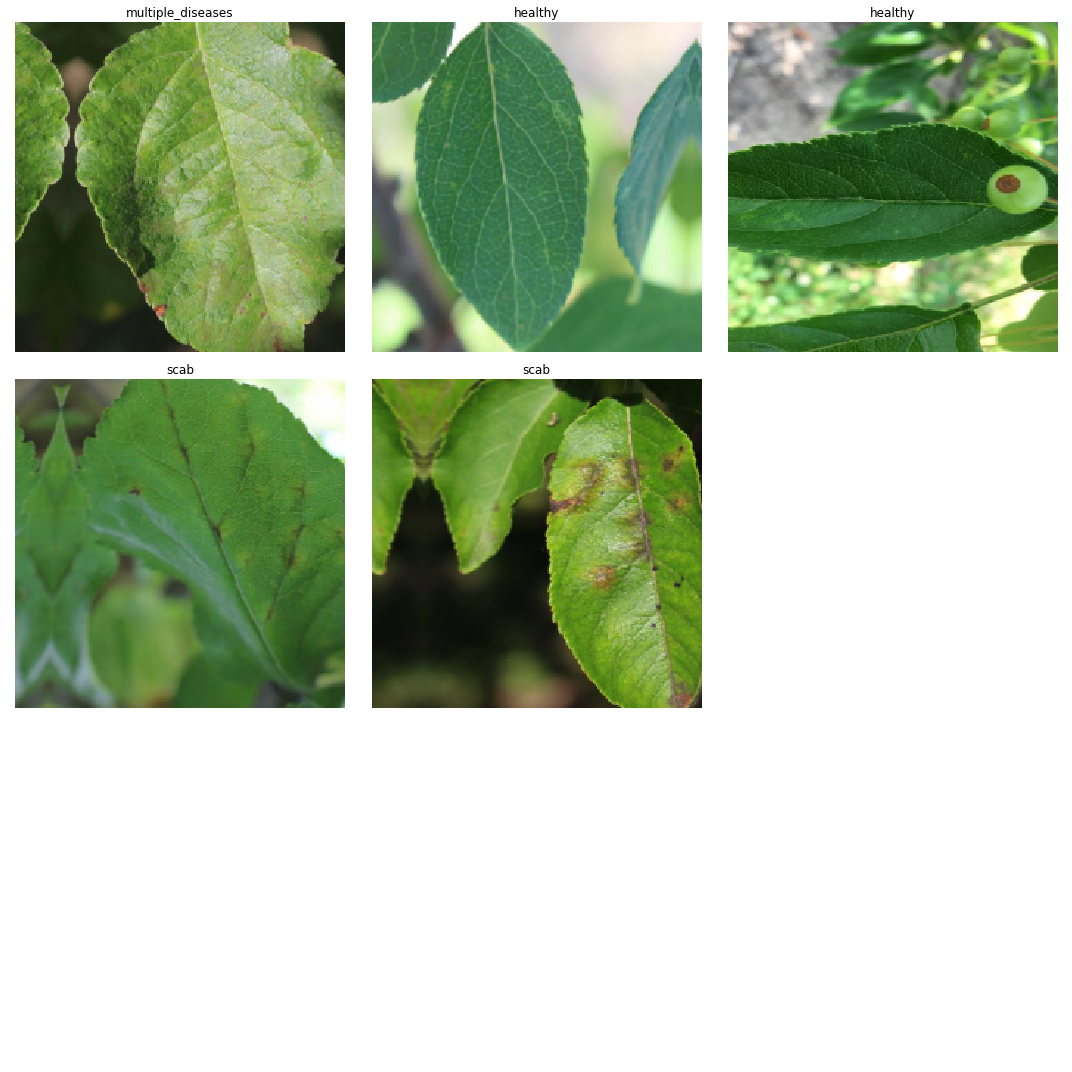

In [16]:
data.show_batch(rows=3, figsize=(15,15))

In [17]:
print(data.classes)
len(data.classes),data.c

['healthy', 'multiple_diseases', 'rust', 'scab']


(4, 4)

In [18]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)
#learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn = cnn_learner(data, models.resnet101, metrics=error_rate)

In [19]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [20]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.168831,2.431273,0.226374,01:53
1,0.789171,0.445813,0.101099,01:46
2,0.774045,0.746611,0.116484,01:47


Training Loss is greater than validation loss. Something isn't right

In [19]:
import torch
torch.cuda.empty_cache()

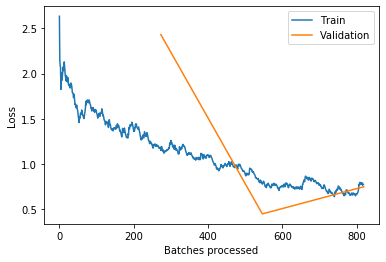

In [21]:
learn.recorder.plot_losses()

In [32]:
#learn.save('stage-1.34.041500')
#learn.save('stage-1.50.041501')
#learn.save('stage-1.50.041512')
#learn.save('stage-1.50.041521') #0.973
learn.save('stage-1.50.041612')

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

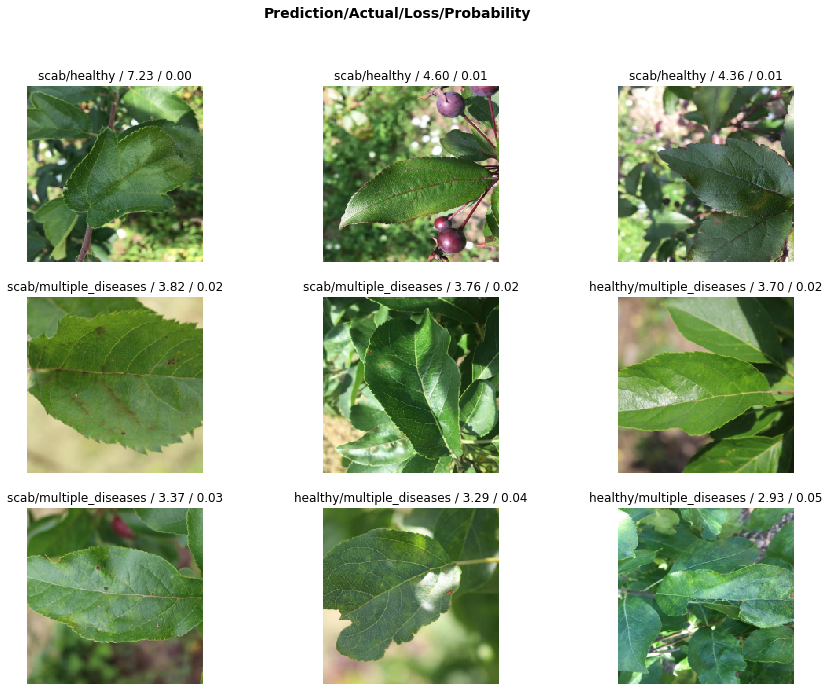

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

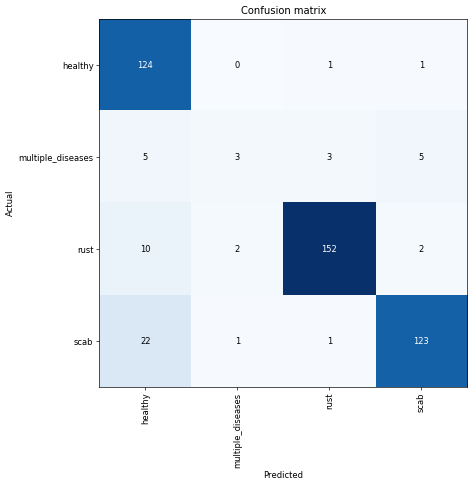

In [24]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [39]:
interp.most_confused(min_val=1)

[('healthy', 'scab', 8),
 ('multiple_diseases', 'scab', 6),
 ('multiple_diseases', 'healthy', 4),
 ('multiple_diseases', 'rust', 4),
 ('scab', 'healthy', 2),
 ('scab', 'rust', 1)]

Check the model after unfreezing

In [88]:
learn.model_dir="/home/manoj/Documents/GitHub/IWildCam2020/models"

In [84]:
#learn.save('~/stage-1.34.040201') # 400X400 images

Exception: [Errno 30] Read-only file system: '/home/manoj/Documents/data/data/iwildcam-2020/train/400X400/models/tmpofrsoud6'
Can't write to '/home/manoj/Documents/data/data/iwildcam-2020/train/400X400/models', set `learn.model_dir` attribute in Learner to a full libpath path that is writable

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


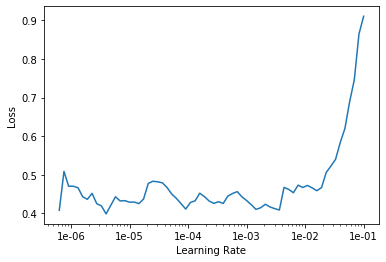

In [21]:
learn.recorder.plot()

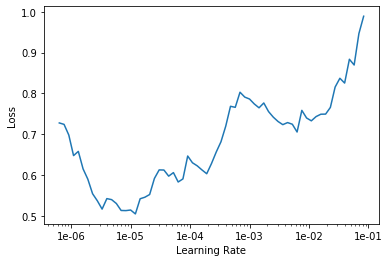

In [26]:
learn.recorder.plot()

In [27]:
learn.unfreeze()

In [29]:
#learn.fit_one_cycle(10, max_lr=slice(1e-5,3e-4))
#learn.fit_one_cycle(5, max_lr=slice(8e-5,3e-5)) # 0.947
#learn.fit_one_cycle(20, max_lr=slice(8e-5,3e-4)) # 0.942
#learn.fit_one_cycle(10, max_lr=slice(9e-4,2e-3))
#learn.fit_one_cycle(20, max_lr=slice(1e-3)) # 0.942
#learn.fit_one_cycle(20, max_lr=slice(1e-2,8e-2))
learn.fit_one_cycle(10, max_lr=slice(5e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.340458,0.467974,0.107143,01:14
1,0.325291,0.377159,0.104396,01:14
2,0.297431,0.321477,0.085165,01:14
3,0.344697,1.918868,0.230769,01:14
4,0.510116,2.433681,0.228022,01:14
5,0.538660,0.705776,0.148352,01:14
6,0.539984,0.533347,0.159341,01:14
7,0.483846,0.412140,0.142857,01:14
8,0.426345,0.228720,0.060440,01:14
9,0.352533,0.195301,0.049451,01:14


In [28]:
#learn.fit_one_cycle(10, max_lr=slice(1e-5,3e-4))
#learn.fit_one_cycle(5, max_lr=slice(8e-5,3e-5)) # 0.947
#learn.fit_one_cycle(20, max_lr=slice(8e-5,3e-4)) # 0.942
#learn.fit_one_cycle(10, max_lr=slice(9e-4,2e-3))
#learn.fit_one_cycle(20, max_lr=slice(1e-3)) # 0.942
#learn.fit_one_cycle(20, max_lr=slice(1e-2,8e-2))
learn.fit_one_cycle(10, max_lr=slice(5e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.616787,0.495292,0.112088,02:02
1,0.773903,0.843926,0.120879,02:01
2,0.605291,0.607543,0.101099,02:00
3,0.529689,0.853638,0.125275,02:01
4,0.572958,0.920308,0.129670,02:00
5,0.459128,0.424256,0.096703,02:01
6,0.596597,0.359673,0.083516,02:02
7,0.466017,0.309034,0.087912,01:58
8,0.420339,0.547586,0.083516,02:00
9,0.474868,0.491714,0.092308,02:00


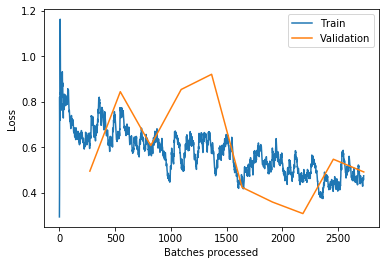

In [29]:
learn.recorder.plot_losses()

In [47]:
learn.fit_one_cycle(20, max_lr=slice(1e-2,8e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.049663,0.164351,0.041209,01:15
1,0.049006,0.172107,0.054945,01:14
2,0.043449,0.193554,0.049451,01:14
3,0.061073,0.252199,0.074176,01:16
4,0.115863,0.343759,0.090659,01:15
5,0.192905,3.783537,0.282967,01:16
6,0.328675,3.372276,0.241758,01:14
7,0.479699,2.281793,0.123626,01:15
8,0.583173,1.222280,0.137363,01:14
9,0.576020,0.666990,0.082418,01:14


In [23]:
learn.fit_one_cycle(20, max_lr=slice(1e-3,5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.702430,0.896783,0.230769,01:35
1,0.702308,0.253467,0.068681,01:33
2,0.595002,1.099444,0.274725,01:34
3,0.733703,0.634339,0.131868,01:34
4,0.738784,4.042849,0.527473,01:32
5,0.770986,1.140623,0.269231,01:34
6,0.707193,0.497482,0.126374,01:34
7,0.678057,1.126333,0.315934,01:33
8,0.798153,0.508205,0.129121,01:33
9,0.596899,0.370011,0.118132,01:32


In [30]:
learn.fit_one_cycle(20, max_lr=slice(5e-6,6e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.309455,0.200359,0.060440,01:33
1,0.274738,0.200968,0.057692,01:34
2,0.261448,0.192620,0.065934,01:33
3,0.250958,0.229286,0.071429,01:33
4,0.283505,0.187748,0.060440,01:34
5,0.264483,0.193879,0.054945,01:33
6,0.265070,0.241486,0.068681,01:34
7,0.241027,0.198972,0.063187,01:32
8,0.227588,0.213049,0.071429,01:33
9,0.251496,0.190348,0.057692,01:33


In [ ]:

learn.fit_one_cycle(200, max_lr=slice(1e-5,2e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.296631,0.218803,0.068681,01:33
1,0.301298,0.195610,0.065934,01:33
2,0.230971,0.202581,0.060440,01:33
3,0.267645,0.196386,0.057692,01:33
4,0.282202,0.190501,0.060440,01:33
5,0.251670,0.199046,0.063187,01:33
6,0.268599,0.191759,0.060440,01:34
7,0.263587,0.199291,0.060440,01:33
8,0.300132,0.193831,0.057692,01:33
9,0.282301,0.187171,0.065934,01:33


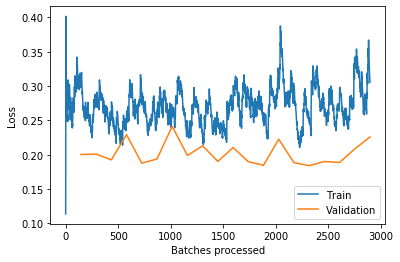

In [31]:
learn.recorder.plot_losses()

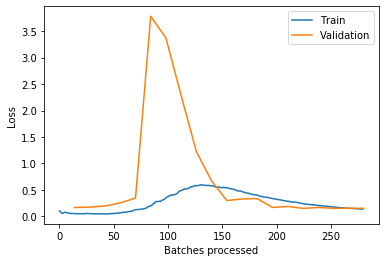

In [48]:
learn.recorder.plot_losses()

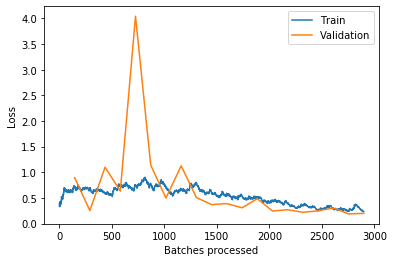

In [24]:
learn.recorder.plot_losses()

In [49]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [45]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


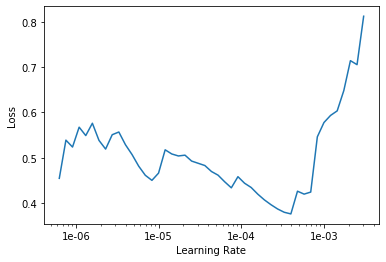

In [31]:
learn.recorder.plot()

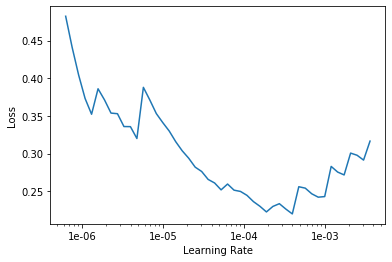

In [46]:
learn.recorder.plot()

In [32]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(10, max_lr=slice(1e-4,4e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.553612,0.465070,0.081319,02:00
1,0.715912,0.405760,0.114286,02:00
2,1.009166,0.756960,0.307692,02:01
3,0.779610,2.068564,0.193407,02:01
4,0.672236,0.389285,0.118681,02:00
5,0.651352,0.509345,0.105495,01:57
6,0.638558,0.262026,0.070330,02:00
7,0.596931,0.240476,0.052747,02:00
8,0.522699,0.223917,0.048352,02:00
9,0.395575,0.254407,0.054945,02:00


In [43]:
learn.fit_one_cycle(20, max_lr=slice(2e-4,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.257824,8.630254,0.193407,02:01
1,0.333156,10.164343,0.191209,02:02
2,0.290587,51.048271,0.345055,01:57
3,0.290722,0.740509,0.098901,02:00
4,0.397411,5.821309,0.259341,02:01
5,0.474417,1.180411,0.158242,02:00
6,0.525306,0.322649,0.076923,02:01
7,0.426982,0.223166,0.057143,02:02
8,0.420005,0.223507,0.054945,01:59
9,0.444568,0.276112,0.081319,02:01


In [62]:
learn.fit_one_cycle(200, max_lr=slice(2e-4,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.187898,0.180778,0.048352,02:01
1,0.338690,0.176697,0.050549,02:00
2,0.179773,0.188141,0.048352,01:58
3,0.241629,0.180105,0.041758,02:01
4,0.209889,0.180938,0.048352,02:00
5,0.246378,0.191031,0.050549,01:59
6,0.206714,0.182982,0.050549,02:00
7,0.195517,0.202045,0.046154,02:00
8,0.290147,0.173484,0.043956,02:00
9,0.216051,0.176958,0.048352,02:01


In [86]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-7))

epoch,train_loss,valid_loss,error_rate,time
0,0.067957,0.156362,0.032967,02:03
1,0.049347,0.137092,0.032967,02:02
2,0.039211,0.138729,0.032967,02:02


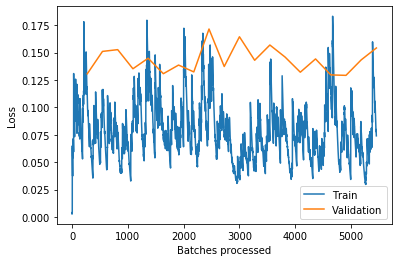

In [82]:
learn.recorder.plot_losses()

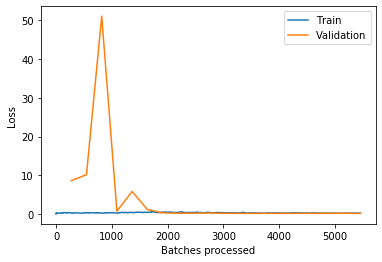

In [44]:
learn.recorder.plot_losses()

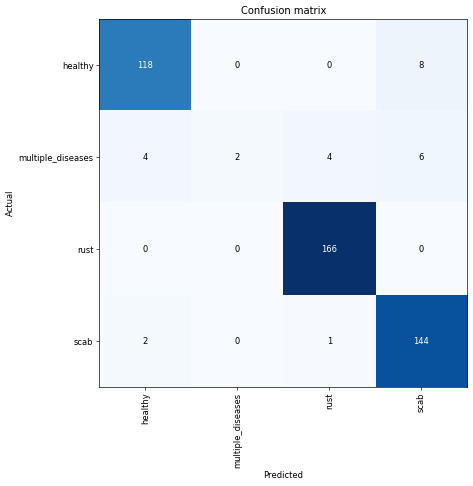

In [36]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [64]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


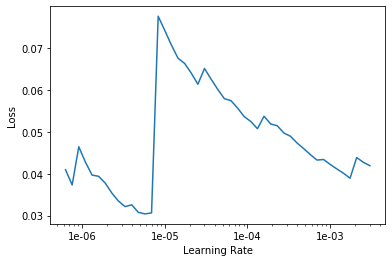

In [65]:
learn.recorder.plot()

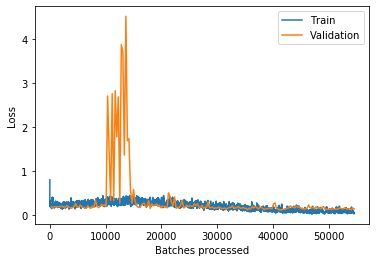

In [63]:
learn.recorder.plot_losses()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
#learn.fit_one_cycle(10, max_lr=slice(1e-5,3e-4))
#learn.fit_one_cycle(5, max_lr=slice(8e-5,3e-5)) # 0.947
#learn.fit_one_cycle(10, max_lr=slice(8e-5,3e-5)) # 0.942
learn.fit_one_cycle(20, max_lr=slice(1e-6,4e-5))

epoch,train_loss,valid_loss,error_rate,time
0,1.270554,1.256894,0.684066,02:49
1,1.226104,1.259711,0.714286,02:51
2,1.309768,1.258846,0.678571,02:47
3,1.245591,1.257693,0.681319,02:51
4,1.267594,1.255317,0.695055,02:52


The training losses are still greater than validation losses

Much better! But can be better. Maybe the learning rate needs to be reduced!

In [66]:
#learn.save('stage-1.34.04150045') # 224*224 images, max_lr=slice(1e-5,3e-4) resnet34 0.924
#learn.save('stage-1.50.041502') # 400*400 images, max_lr=slice(8e-5,3e-5) resnet50 0.947
#learn.save('stage-1.50.041511') # 400*400 images, max_lr=slice(8e-5,3e-5) resnet50 
#learn.save('stage-1.50.041523') # 600*533 images, resnet50 , 0.973 
#learn.save('stage-1.50.041600') # 600*533 images, resnet50 , 
#learn=learn.load('tmp') # 600*533 images, resnet50 , 0.973 
#learn.save('stage-1.50.04162147') # 600*533 images, resnet50 , 0.973 
#learn.save('stage-1.101.04162252') # 600*533 images, resnet101 , 
#learn.save('stage-1.101.04162355') # 600*533 images, resnet101 , 0.973 
#learn.save('stage-1.101.04290235') # 600*533 images, resnet101 , #0.941 
learn.save('stage-1.101.04290500') # 600*533 images, resnet101 , #to test

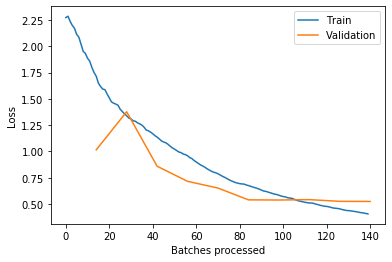

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


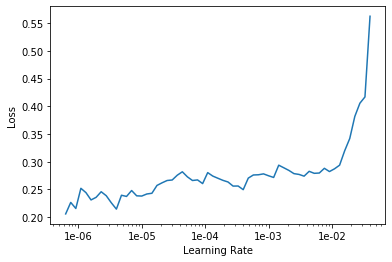

In [27]:
learn.recorder.plot()

Maybe a few more fittings will make the losses better

In [67]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

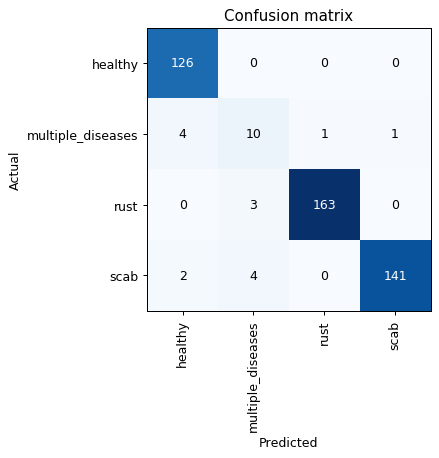

In [68]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=90)

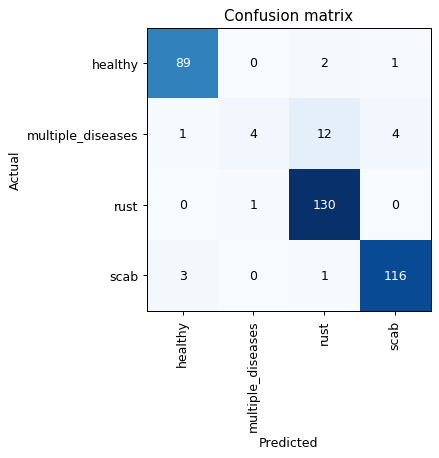

In [37]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=90)

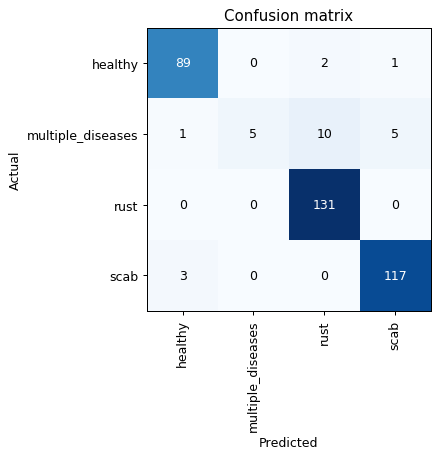

In [29]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=90)

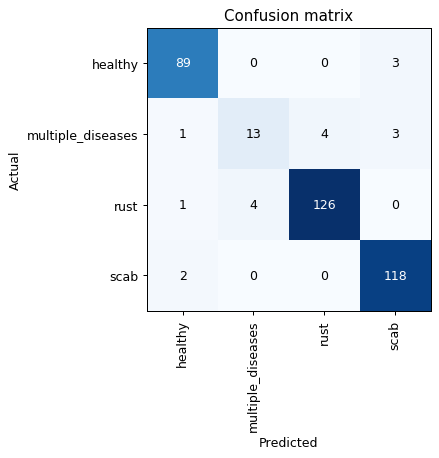

In [53]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=90)

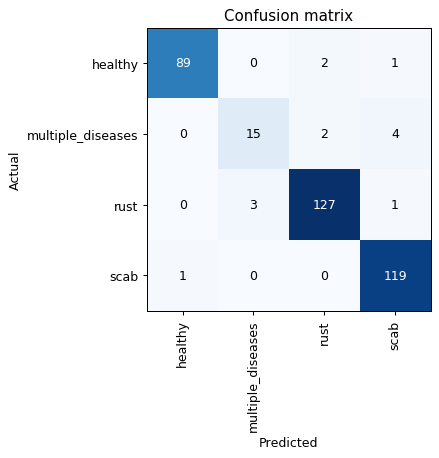

In [34]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=90)

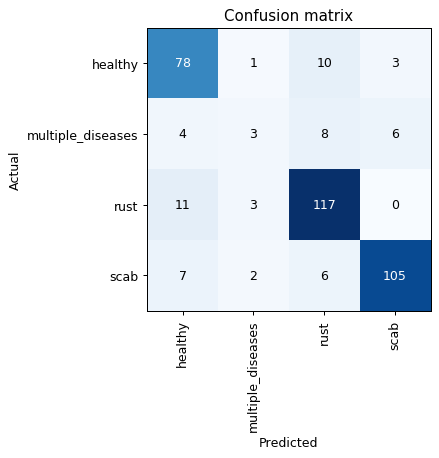

In [28]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=90)

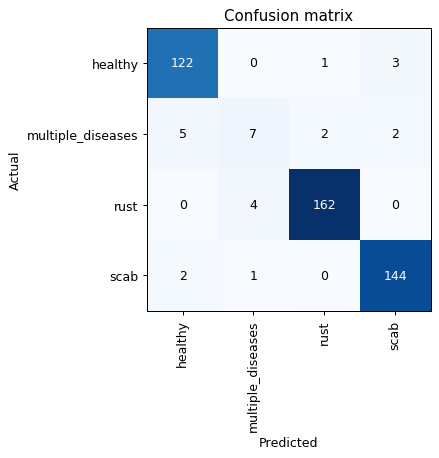

In [49]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=90)

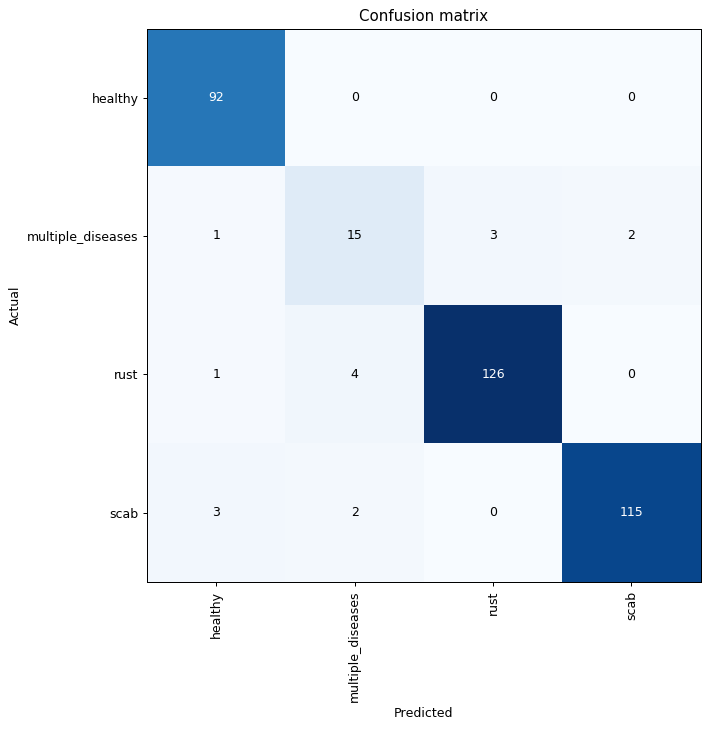

In [65]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=90)

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=90)

In [69]:
testImagesDf=pd.read_csv(dataPath/'test.csv')

In [70]:
#testImagesDf["name"]=testImagesDf["image_id"]+".jpg"
testImagesDf

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
...,...
1816,Test_1816
1817,Test_1817
1818,Test_1818
1819,Test_1819


In [71]:
#testPath=Path("/home/manoj/Documents/data/data/iwildcam-2020/test/100X100")
testPath=dataPath/'images'

In [72]:
testPath.ls()[10]

WindowsPath('c:/Users/manoj/PycharmProjects/data/PlantPathology2020/images/Test_1005.jpg')

In [73]:
np.asarray(tensor([1.3910e-04, 6.2275e-03, 9.9363e-01, 1.0434e-07]))[1]

0.0062275

In [ ]:
learn.predict(open_image(testPath/(file+".jpg"))

In [74]:
#predictions1 = [ [image_id, np.asarray(learn.predict(open_image(testPath/(image_id+".jpg")), True)[3]).tolist()] for image_id in testImagesDf["image_id"]]
i=0

options = { 0:"healthy"
           ,1:"multiple_diseases"
           ,2:"rust"
           ,3:"scab"
}
df2=[]
for file in testImagesDf["image_id"]:
    if(i<len(testImagesDf)):
        x=np.asarray(learn.predict(open_image(testPath/(file+".jpg")), True)[3]).tolist()
        cols=dict({"image_id":file})
        
        for j in range(4):
            cols.update({options[j]:x[j]})
        df2.append(cols)
        i=i+1

In [75]:
df2=pd.DataFrame(df2)

In [76]:
submissionFilePath=dataPath/'sample_submission.csv'
submission=pd.read_csv(submissionFilePath)

In [77]:
submission

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25
...,...,...,...,...,...
1816,Test_1816,0.25,0.25,0.25,0.25
1817,Test_1817,0.25,0.25,0.25,0.25
1818,Test_1818,0.25,0.25,0.25,0.25
1819,Test_1819,0.25,0.25,0.25,0.25


In [78]:
#df2=submission.merge(df1, on="Id")[["Id","Category"]]
df3=submission.merge(df2, on="image_id", how="inner", suffixes=('_x', ''))[["image_id","healthy","multiple_diseases","rust","scab"]]

In [44]:
? submission.merge

In [79]:
df3

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.008966,0.010457,0.980045,0.000532
1,Test_1,0.003620,0.002934,0.992509,0.000937
2,Test_2,0.001438,0.000101,0.000162,0.998299
3,Test_3,0.992040,0.000066,0.007416,0.000478
4,Test_4,0.001418,0.020472,0.975538,0.002573
...,...,...,...,...,...
1816,Test_1816,0.001768,0.013731,0.983549,0.000952
1817,Test_1817,0.001090,0.000410,0.000319,0.998181
1818,Test_1818,0.004784,0.007482,0.987361,0.000373
1819,Test_1819,0.961421,0.003406,0.028677,0.006496


In [57]:
#df["file_name"]

In [80]:
#df3.to_csv("submission.202004150140.csv", index=False) 0.924
#df3.to_csv("submission.2020041500210.csv", index=False) 0.947
#df3.to_csv("submission.202004151225.csv", index=False) 0.942
#df3.to_csv("submission.202004152026.csv", index=False) # 0.945
#df3.to_csv("submission.202004152117.csv", index=False) # 0.973
#df3.to_csv("submission.20200415235.csv", index=False) # 
#df3.to_csv("submission.2020041617.csv", index=False) # 
#df3.to_csv("submission.202004290225.csv", index=False) # 0.5
df3.to_csv("submission.202004300400.csv", index=False) # to test